In [ ]:
#Version using the convolutional + GRU layer inspired by Masuda paper

import numpy as np
import torch
import torch.nn as nn
import ddx7.loss_functions
import yaml
from ddx7.data_utils.h5_dataset import h5Dataset
from torch.utils.data import DataLoader, random_split
import model as mod
import synth
import trainer as tr
import datetime


In [ ]:

%reload_ext tensorboard
%tensorboard --logdir logs --host localhost

In [5]:
#define h5 data loaders


def get_loaders(instrument,data_dir,train_split = 0.80,batch_size=16,device='cpu',load_additional_testset=False):

    
    # Loading Data and splitting it into train validation and test data
    traindata_path = '{}'.format(f'./{data_dir}/train/{instrument}/16000.h5') #fix this
    input_keys = ('audio','f0','mfcc', 'mfcc_length')
    traindset = h5Dataset(sr=16000,
                    data_path=traindata_path,
                    input_keys=input_keys,
                    max_audio_val=1,
                    device=device)

    audio_length = traindset[0]['audio'].shape[0]
    mfcc_length = traindset[0]['mfcc'].shape[1]

    
        
    train_split = int(train_split*len(traindset))
    test_split = (len(traindset)-train_split) // 2
    val_split = len(traindset)-train_split - test_split
    train, valid,test = random_split(traindset,[train_split,val_split,test_split])


    trainloader = DataLoader(train,
                            batch_size=batch_size,
                            shuffle = True,
                            drop_last=True)
    validloader = DataLoader(valid,
                            batch_size=batch_size,
                            shuffle = False,
                            drop_last=False) #Dont drop last for validation. Use all the data for validation.

    testloader = DataLoader(test,
                            batch_size=batch_size,
                            shuffle = False,
                            drop_last=False) #Dont drop last for test. Use all the data for test.


    print('[INFO] Train Dataset len: {}'.format(len(train)))
    print('[INFO] Valid Dataset len: {}'.format(len(valid)))
    print('[INFO] Test Dataset len: {}'.format(len(test)))
    loaders = {}
    loaders['train'] = trainloader
    loaders['valid'] = validloader
    loaders['test'] = testloader

    if(load_additional_testset == True):
        # Now load test with additional, non-URMP, audio excerpts.
        testcdata_path = '{}{}'.format(hydra.utils.get_original_cwd(), f'/{data_dir}/test/{instrument}/16000.h5')
        test_cnt = h5Dataset(sr=16000,
                        data_path=testcdata_path,
                        input_keys=input_keys,
                        max_audio_val=1,
                        device='cpu') #Force test set on CPU

        testcloader = DataLoader(test_cnt,
                                batch_size=1, # Always batch size of 1 for continuous test
                                shuffle = False, #don't shuffle for test set.
                                drop_last=False)

        print('[INFO] Test Continuous Dataset len: {}'.format(len(test_cnt)))
        loaders['test_cnt'] = testcloader

    return loaders, mfcc_length, audio_length


#test loaders

data_dir = 'dataset/data'
instrument = 'violin_laia_improvement_recordings/neumann'

loaders, mfcc_length, audio_length = get_loaders(instrument,data_dir)

#for debug
for x in loaders['valid']:
    print(x['mfcc'].shape)
print(audio_length)
print(mfcc_length)

[INFO] Train Dataset len: 264
[INFO] Valid Dataset len: 33
[INFO] Test Dataset len: 33
torch.Size([16, 20, 212, 1])
torch.Size([16, 20, 212, 1])
torch.Size([1, 20, 212, 1])
108477
212


In [3]:
#Testing the new model
model = mod.MelEstimator(output_dim=6+6+6*6)
modelwithsynth = mod.MelPlusSynth(num_outputs=6+6+6*6, audio_length=audio_length)


STFT kernels created, time used = 0.0140 seconds
STFT filter created, time used = 0.0020 seconds
Mel filter created, time used = 0.0020 seconds
output dims after convolution 16
STFT kernels created, time used = 0.0130 seconds
STFT filter created, time used = 0.0010 seconds
Mel filter created, time used = 0.0010 seconds
output dims after convolution 16


In [4]:
for x in loaders['train']:
    #x['audio'] = x['audio'].permute(0, 2, 1) #nnAudio stft requires this format (audio length must be last dimension)
    #print(x['audio'].shape)
    out = modelwithsynth(x)
    print(out)
    break

16 128 424
{'synth_audio': tensor([[ 1.0455e-01,  4.5501e-03,  4.6143e-01,  ...,  1.7918e-02,
          9.0664e-02,  1.5264e-01],
        [-2.5562e-02,  3.4205e-01, -1.6453e-02,  ..., -5.9055e-01,
         -5.8305e-01, -5.7213e-01],
        [-5.4308e-02,  4.6313e-01, -5.2472e-02,  ..., -2.3850e-01,
         -6.0941e-01, -5.8299e-01],
        ...,
        [ 3.1782e-01,  1.3622e-01,  3.5480e-01,  ..., -3.2819e-02,
         -2.7195e-04,  5.8728e-02],
        [ 2.3229e-02,  1.5967e-01,  2.6821e-01,  ...,  4.2302e-01,
          4.9612e-01,  4.4612e-01],
        [ 2.8913e-01,  1.0817e-01,  3.5501e-01,  ...,  1.8339e-01,
          1.1216e-02, -3.7267e-02]], grad_fn=<DivBackward0>), 'mod_index': tensor([[1.2235, 1.2052, 1.2389, 1.2332, 1.2511, 1.2733],
        [1.2235, 1.2052, 1.2389, 1.2332, 1.2511, 1.2733],
        [1.2235, 1.2052, 1.2389, 1.2332, 1.2511, 1.2733],
        [1.2235, 1.2052, 1.2389, 1.2332, 1.2511, 1.2733],
        [1.2235, 1.2052, 1.2389, 1.2332, 1.2511, 1.2733],
        [1.22

In [8]:
#the main training function

#Load YAML file for training config
hyperparams_yml = yaml.safe_load(open('ddx7/recipes/hyperparams/ddx7.yaml'))
print(hyperparams_yml)



def main_training():
    torch.manual_seed(1234)

    data_dir = 'dataset/data'
    instrument = 'violin_laia_improvement_recordings/neumann'

    loaders, mfcc_length , audio_length = get_loaders(instrument,data_dir)

    steps=3000
    lr=3e-4
    loss_fn = ddx7.loss_functions.rec_loss(scales=[2048, 1024, 512, 256, 128, 64], overlap=0.75)
    #steps=hyperparams_yml['steps']

    hyperparams = tr.Hyperparams(steps,loss_fn,hyperparams_yml['opt'],hyperparams_yml['scheduler'],lr,
                              hyperparams_yml['lr_decay_steps'],hyperparams_yml['lr_decay_rate'],hyperparams_yml['n_store_best'],
                              hyperparams_yml['batch_size'])

    
    # After instantiation, adjust hyperparam config (will not need this in Hydra 1.2)
    if hyperparams.opt == 'Adam':
        hyperparams.opt = torch.optim.Adam
    if hyperparams.scheduler == 'ExponentialLR':
        hyperparams.scheduler = torch.optim.lr_scheduler.ExponentialLR

    sequence_length = mfcc_length #adjust
    num_features = 20
    num_outputs = 6 + 6 + 6*6 #6 freq ratio + 6 mod index + adsr control (6) for each oscillator (6 oscillators)
    batch_size = hyperparams_yml['batch_size']
    input_shape = (batch_size, sequence_length, num_features)  # Update with actual values
    #training_logs_path = './logs/20231103-235544'
    training_logs_path = './logs/2_layers_GRU/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model = mod.MelPlusSynth(num_outputs=6+6+6*6, audio_length=audio_length)
    trainer = tr.Trainer(loaders=loaders,
                    hyperparams=hyperparams,
                    device = 'cpu:0', training_logs_path=training_logs_path)


    #resume_epoch=0 for training from scratch
    #resume_epoch=-1 to start from best checkpoint
    #in the latter case be sure to use the same training_logs_path folder!
    
    trainer.run(model, resume_epoch=0)


    #Testing the model
    #the mfcc data tensor should have the two last dimensions permuted (first should come sequence length and the number of features)
#    for x in loaders['train']:
#        print('madonna')
#        out = model(x)
#        print(out)
#        break

    

main_training()


{'_target_': 'trainer.Hyperparams', 'steps': 120000, 'loss_fn': {'_target_': 'ddx7.loss_functions.rec_loss', 'scales': [2048, 1024, 512, 256, 128, 64], 'overlap': 0.75}, 'scheduler': 'ExponentialLR', 'opt': 'Adam', 'lr': '3e-4', 'lr_decay_rate': 0.98, 'lr_decay_steps': 10000, 'grad_clip_norm': 2.0, 'batch_size': 16, 'n_store_best': 20}
[INFO] Train Dataset len: 264
[INFO] Valid Dataset len: 33
[INFO] Test Dataset len: 33
STFT kernels created, time used = 0.0140 seconds
STFT filter created, time used = 0.0010 seconds
Mel filter created, time used = 0.0010 seconds
output dims after convolution 16
[INFO] Model has 4021296 trainable parameters.


  0%|                                                                                          | 0/188 [00:00<?, ?it/s]

16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
1 128 424


  1%|▍                                                                               | 1/188 [01:00<3:09:28, 60.79s/it]

16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  1%|▊                                                                               | 2/188 [02:02<3:09:28, 61.12s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  2%|█▎                                                                              | 3/188 [03:03<3:08:07, 61.01s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  2%|█▋                                                                              | 4/188 [04:01<3:04:17, 60.10s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  3%|██▏                                                                             | 5/188 [04:59<3:00:41, 59.24s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  3%|██▌                                                                             | 6/188 [05:56<2:57:35, 58.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  4%|██▉                                                                             | 7/188 [06:54<2:55:59, 58.34s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  4%|███▍                                                                            | 8/188 [07:52<2:55:02, 58.35s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  5%|███▊                                                                            | 9/188 [08:51<2:53:50, 58.27s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  5%|████▏                                                                          | 10/188 [09:48<2:52:09, 58.03s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  6%|████▌                                                                          | 11/188 [10:46<2:50:47, 57.90s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  6%|█████                                                                          | 12/188 [11:43<2:49:29, 57.78s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  7%|█████▍                                                                         | 13/188 [12:41<2:48:23, 57.74s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  7%|█████▉                                                                         | 14/188 [13:38<2:47:06, 57.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  8%|██████▎                                                                        | 15/188 [14:36<2:46:05, 57.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  9%|██████▋                                                                        | 16/188 [15:33<2:44:55, 57.53s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


  9%|███████▏                                                                       | 17/188 [16:31<2:44:06, 57.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 10%|███████▌                                                                       | 18/188 [17:28<2:43:06, 57.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 10%|███████▉                                                                       | 19/188 [18:26<2:42:18, 57.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 11%|████████▍                                                                      | 20/188 [19:24<2:41:22, 57.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 11%|████████▊                                                                      | 21/188 [20:21<2:40:20, 57.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 12%|█████████▏                                                                     | 22/188 [21:19<2:39:18, 57.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 12%|█████████▋                                                                     | 23/188 [22:17<2:38:39, 57.69s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 13%|██████████                                                                     | 24/188 [23:13<2:36:42, 57.33s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 13%|██████████▌                                                                    | 25/188 [24:10<2:35:08, 57.11s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 14%|██████████▉                                                                    | 26/188 [25:06<2:33:40, 56.92s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 14%|███████████▎                                                                   | 27/188 [26:03<2:32:24, 56.80s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 15%|███████████▊                                                                   | 28/188 [26:59<2:31:16, 56.73s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 15%|████████████▏                                                                  | 29/188 [27:56<2:29:58, 56.60s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 16%|████████████▌                                                                  | 30/188 [28:52<2:29:07, 56.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 16%|█████████████                                                                  | 31/188 [29:49<2:28:12, 56.64s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 17%|█████████████▍                                                                 | 32/188 [30:46<2:27:12, 56.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 18%|█████████████▊                                                                 | 33/188 [31:42<2:26:02, 56.53s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 18%|██████████████▎                                                                | 34/188 [32:38<2:25:07, 56.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 19%|██████████████▋                                                                | 35/188 [33:35<2:24:14, 56.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 19%|███████████████▏                                                               | 36/188 [34:31<2:23:07, 56.49s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 20%|███████████████▌                                                               | 37/188 [35:28<2:22:12, 56.51s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 20%|███████████████▉                                                               | 38/188 [36:25<2:21:19, 56.53s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 21%|████████████████▍                                                              | 39/188 [37:21<2:20:19, 56.50s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 21%|████████████████▊                                                              | 40/188 [38:17<2:19:21, 56.49s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 22%|█████████████████▏                                                             | 41/188 [39:14<2:18:28, 56.52s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 22%|█████████████████▋                                                             | 42/188 [40:10<2:17:29, 56.50s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 23%|██████████████████                                                             | 43/188 [41:07<2:16:23, 56.44s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 23%|██████████████████▍                                                            | 44/188 [42:03<2:15:23, 56.41s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 24%|██████████████████▉                                                            | 45/188 [43:00<2:14:31, 56.44s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 24%|███████████████████▎                                                           | 46/188 [43:56<2:13:25, 56.38s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 25%|███████████████████▊                                                           | 47/188 [44:52<2:12:31, 56.39s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 26%|████████████████████▏                                                          | 48/188 [45:49<2:11:34, 56.39s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 26%|████████████████████▌                                                          | 49/188 [46:45<2:10:24, 56.29s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 27%|█████████████████████                                                          | 50/188 [47:41<2:09:36, 56.35s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 27%|█████████████████████▍                                                         | 51/188 [48:38<2:08:40, 56.36s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 28%|█████████████████████▊                                                         | 52/188 [49:34<2:07:46, 56.37s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 28%|██████████████████████▎                                                        | 53/188 [50:33<2:08:23, 57.07s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 29%|██████████████████████▋                                                        | 54/188 [51:32<2:09:08, 57.82s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 29%|███████████████████████                                                        | 55/188 [52:30<2:08:10, 57.82s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 30%|███████████████████████▌                                                       | 56/188 [53:27<2:06:45, 57.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 30%|███████████████████████▉                                                       | 57/188 [54:24<2:05:15, 57.37s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 31%|████████████████████████▎                                                      | 58/188 [55:21<2:03:58, 57.22s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 31%|████████████████████████▊                                                      | 59/188 [56:18<2:02:50, 57.13s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 32%|█████████████████████████▏                                                     | 60/188 [57:15<2:01:52, 57.13s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 32%|█████████████████████████▋                                                     | 61/188 [58:12<2:00:57, 57.15s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 33%|██████████████████████████                                                     | 62/188 [59:08<1:59:17, 56.80s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 34%|█████████████████████████▊                                                   | 63/188 [1:00:04<1:57:33, 56.43s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 34%|██████████████████████████▏                                                  | 64/188 [1:00:59<1:56:06, 56.18s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 35%|██████████████████████████▌                                                  | 65/188 [1:01:55<1:54:53, 56.04s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 35%|███████████████████████████                                                  | 66/188 [1:02:51<1:53:48, 55.97s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 36%|███████████████████████████▍                                                 | 67/188 [1:03:47<1:52:47, 55.93s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 36%|███████████████████████████▊                                                 | 68/188 [1:04:43<1:52:04, 56.04s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 37%|████████████████████████████▎                                                | 69/188 [1:05:39<1:51:03, 56.00s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 37%|████████████████████████████▋                                                | 70/188 [1:06:34<1:49:49, 55.84s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 38%|█████████████████████████████                                                | 71/188 [1:07:30<1:48:43, 55.75s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 38%|█████████████████████████████▍                                               | 72/188 [1:08:26<1:47:43, 55.72s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 39%|█████████████████████████████▉                                               | 73/188 [1:09:21<1:46:45, 55.70s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 39%|██████████████████████████████▎                                              | 74/188 [1:10:17<1:45:37, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 40%|██████████████████████████████▋                                              | 75/188 [1:11:12<1:44:49, 55.66s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 40%|███████████████████████████████▏                                             | 76/188 [1:12:08<1:43:48, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 41%|███████████████████████████████▌                                             | 77/188 [1:13:03<1:42:46, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 41%|███████████████████████████████▉                                             | 78/188 [1:13:59<1:41:53, 55.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 42%|████████████████████████████████▎                                            | 79/188 [1:14:54<1:40:53, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 43%|████████████████████████████████▊                                            | 80/188 [1:15:50<1:39:55, 55.52s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 43%|█████████████████████████████████▏                                           | 81/188 [1:16:46<1:39:08, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 44%|█████████████████████████████████▌                                           | 82/188 [1:17:41<1:38:10, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 44%|█████████████████████████████████▉                                           | 83/188 [1:18:37<1:37:13, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 45%|██████████████████████████████████▍                                          | 84/188 [1:19:32<1:36:16, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 45%|██████████████████████████████████▊                                          | 85/188 [1:20:28<1:35:29, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 46%|███████████████████████████████████▏                                         | 86/188 [1:21:23<1:34:26, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 46%|███████████████████████████████████▋                                         | 87/188 [1:22:19<1:33:34, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 47%|████████████████████████████████████                                         | 88/188 [1:23:15<1:32:40, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 47%|████████████████████████████████████▍                                        | 89/188 [1:24:10<1:31:38, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 48%|████████████████████████████████████▊                                        | 90/188 [1:25:06<1:30:43, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 48%|█████████████████████████████████████▎                                       | 91/188 [1:26:01<1:29:51, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 49%|█████████████████████████████████████▋                                       | 92/188 [1:26:57<1:28:56, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 49%|██████████████████████████████████████                                       | 93/188 [1:27:52<1:27:59, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 50%|██████████████████████████████████████▌                                      | 94/188 [1:28:48<1:27:07, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 51%|██████████████████████████████████████▉                                      | 95/188 [1:29:44<1:26:06, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 51%|███████████████████████████████████████▎                                     | 96/188 [1:30:39<1:25:06, 55.51s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 52%|███████████████████████████████████████▋                                     | 97/188 [1:31:35<1:24:17, 55.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 52%|████████████████████████████████████████▏                                    | 98/188 [1:32:30<1:23:23, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 53%|████████████████████████████████████████▌                                    | 99/188 [1:33:26<1:22:27, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 53%|████████████████████████████████████████▍                                   | 100/188 [1:34:21<1:21:29, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 54%|████████████████████████████████████████▊                                   | 101/188 [1:35:17<1:20:33, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 54%|█████████████████████████████████████████▏                                  | 102/188 [1:36:13<1:19:39, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 55%|█████████████████████████████████████████▋                                  | 103/188 [1:37:08<1:18:37, 55.50s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 55%|██████████████████████████████████████████                                  | 104/188 [1:38:03<1:17:41, 55.50s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 56%|██████████████████████████████████████████▍                                 | 105/188 [1:38:59<1:16:48, 55.52s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 56%|██████████████████████████████████████████▊                                 | 106/188 [1:39:54<1:15:54, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 57%|███████████████████████████████████████████▎                                | 107/188 [1:40:50<1:15:00, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 57%|███████████████████████████████████████████▋                                | 108/188 [1:41:46<1:14:07, 55.60s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 58%|████████████████████████████████████████████                                | 109/188 [1:42:41<1:13:08, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 59%|████████████████████████████████████████████▍                               | 110/188 [1:43:37<1:12:09, 55.50s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 59%|████████████████████████████████████████████▊                               | 111/188 [1:44:32<1:11:20, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 60%|█████████████████████████████████████████████▎                              | 112/188 [1:45:28<1:10:29, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 60%|█████████████████████████████████████████████▋                              | 113/188 [1:46:24<1:09:34, 55.66s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 61%|██████████████████████████████████████████████                              | 114/188 [1:47:19<1:08:36, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 61%|██████████████████████████████████████████████▍                             | 115/188 [1:48:15<1:07:34, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 62%|██████████████████████████████████████████████▉                             | 116/188 [1:49:10<1:06:41, 55.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 62%|███████████████████████████████████████████████▎                            | 117/188 [1:50:06<1:05:47, 55.60s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 63%|███████████████████████████████████████████████▋                            | 118/188 [1:51:02<1:04:55, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 63%|████████████████████████████████████████████████                            | 119/188 [1:51:57<1:03:52, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 64%|████████████████████████████████████████████████▌                           | 120/188 [1:52:53<1:03:03, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 64%|████████████████████████████████████████████████▉                           | 121/188 [1:53:49<1:02:06, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 65%|█████████████████████████████████████████████████▎                          | 122/188 [1:54:44<1:01:11, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 65%|█████████████████████████████████████████████████▋                          | 123/188 [1:55:40<1:00:15, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 66%|███████████████████████████████████████████████████▍                          | 124/188 [1:56:36<59:20, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 66%|███████████████████████████████████████████████████▊                          | 125/188 [1:57:31<58:24, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 67%|████████████████████████████████████████████████████▎                         | 126/188 [1:58:27<57:25, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 68%|████████████████████████████████████████████████████▋                         | 127/188 [1:59:22<56:32, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 68%|█████████████████████████████████████████████████████                         | 128/188 [2:00:18<55:39, 55.66s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 69%|█████████████████████████████████████████████████████▌                        | 129/188 [2:01:13<54:35, 55.52s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 69%|█████████████████████████████████████████████████████▉                        | 130/188 [2:02:09<53:40, 55.53s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 70%|██████████████████████████████████████████████████████▎                       | 131/188 [2:03:04<52:45, 55.53s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 70%|██████████████████████████████████████████████████████▊                       | 132/188 [2:04:00<51:51, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 71%|███████████████████████████████████████████████████████▏                      | 133/188 [2:04:56<50:58, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 71%|███████████████████████████████████████████████████████▌                      | 134/188 [2:05:51<50:03, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 72%|████████████████████████████████████████████████████████                      | 135/188 [2:06:47<49:08, 55.64s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 72%|████████████████████████████████████████████████████████▍                     | 136/188 [2:07:43<48:11, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 73%|████████████████████████████████████████████████████████▊                     | 137/188 [2:08:38<47:19, 55.67s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 73%|█████████████████████████████████████████████████████████▎                    | 138/188 [2:09:34<46:26, 55.73s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 74%|█████████████████████████████████████████████████████████▋                    | 139/188 [2:10:30<45:29, 55.71s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 74%|██████████████████████████████████████████████████████████                    | 140/188 [2:11:25<44:30, 55.64s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 75%|██████████████████████████████████████████████████████████▌                   | 141/188 [2:12:21<43:32, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 76%|██████████████████████████████████████████████████████████▉                   | 142/188 [2:13:16<42:37, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 76%|███████████████████████████████████████████████████████████▎                  | 143/188 [2:14:12<41:44, 55.66s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 77%|███████████████████████████████████████████████████████████▋                  | 144/188 [2:15:08<40:48, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 77%|████████████████████████████████████████████████████████████▏                 | 145/188 [2:16:04<39:52, 55.64s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 78%|████████████████████████████████████████████████████████████▌                 | 146/188 [2:16:59<38:53, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 78%|████████████████████████████████████████████████████████████▉                 | 147/188 [2:17:54<37:52, 55.43s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 79%|█████████████████████████████████████████████████████████████▍                | 148/188 [2:18:50<37:02, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 79%|█████████████████████████████████████████████████████████████▊                | 149/188 [2:19:45<36:02, 55.45s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 80%|██████████████████████████████████████████████████████████████▏               | 150/188 [2:20:41<35:10, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 80%|██████████████████████████████████████████████████████████████▋               | 151/188 [2:21:36<34:15, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 81%|███████████████████████████████████████████████████████████████               | 152/188 [2:22:32<33:21, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 81%|███████████████████████████████████████████████████████████████▍              | 153/188 [2:23:28<32:26, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 82%|███████████████████████████████████████████████████████████████▉              | 154/188 [2:24:23<31:32, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 82%|████████████████████████████████████████████████████████████████▎             | 155/188 [2:25:19<30:37, 55.67s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 83%|████████████████████████████████████████████████████████████████▋             | 156/188 [2:26:15<29:41, 55.68s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 84%|█████████████████████████████████████████████████████████████████▏            | 157/188 [2:27:11<28:45, 55.67s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 84%|█████████████████████████████████████████████████████████████████▌            | 158/188 [2:28:06<27:51, 55.71s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 85%|█████████████████████████████████████████████████████████████████▉            | 159/188 [2:29:02<26:56, 55.75s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 85%|██████████████████████████████████████████████████████████████████▍           | 160/188 [2:29:58<26:00, 55.72s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 86%|██████████████████████████████████████████████████████████████████▊           | 161/188 [2:30:54<25:04, 55.73s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 86%|███████████████████████████████████████████████████████████████████▏          | 162/188 [2:31:49<24:07, 55.69s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 87%|███████████████████████████████████████████████████████████████████▋          | 163/188 [2:32:45<23:12, 55.71s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 87%|████████████████████████████████████████████████████████████████████          | 164/188 [2:33:41<22:16, 55.68s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 88%|████████████████████████████████████████████████████████████████████▍         | 165/188 [2:34:36<21:20, 55.66s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 88%|████████████████████████████████████████████████████████████████████▊         | 166/188 [2:35:32<20:24, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 89%|█████████████████████████████████████████████████████████████████████▎        | 167/188 [2:36:27<19:27, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 89%|█████████████████████████████████████████████████████████████████████▋        | 168/188 [2:37:23<18:31, 55.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 90%|██████████████████████████████████████████████████████████████████████        | 169/188 [2:38:19<17:36, 55.63s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 90%|██████████████████████████████████████████████████████████████████████▌       | 170/188 [2:39:14<16:40, 55.56s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 91%|██████████████████████████████████████████████████████████████████████▉       | 171/188 [2:40:10<15:44, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 91%|███████████████████████████████████████████████████████████████████████▎      | 172/188 [2:41:05<14:49, 55.61s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 92%|███████████████████████████████████████████████████████████████████████▊      | 173/188 [2:42:01<13:54, 55.62s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 93%|████████████████████████████████████████████████████████████████████████▏     | 174/188 [2:42:57<12:59, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 93%|████████████████████████████████████████████████████████████████████████▌     | 175/188 [2:43:52<12:02, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 94%|█████████████████████████████████████████████████████████████████████████     | 176/188 [2:44:48<11:06, 55.58s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 94%|█████████████████████████████████████████████████████████████████████████▍    | 177/188 [2:45:43<10:10, 55.51s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 95%|█████████████████████████████████████████████████████████████████████████▊    | 178/188 [2:46:38<09:14, 55.46s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 95%|██████████████████████████████████████████████████████████████████████████▎   | 179/188 [2:47:34<08:19, 55.55s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 96%|██████████████████████████████████████████████████████████████████████████▋   | 180/188 [2:48:30<07:24, 55.54s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 96%|███████████████████████████████████████████████████████████████████████████   | 181/188 [2:49:25<06:29, 55.59s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 97%|███████████████████████████████████████████████████████████████████████████▌  | 182/188 [2:50:21<05:33, 55.57s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 97%|███████████████████████████████████████████████████████████████████████████▉  | 183/188 [2:51:17<04:38, 55.65s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 98%|████████████████████████████████████████████████████████████████████████████▎ | 184/188 [2:52:12<03:41, 55.49s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 98%|████████████████████████████████████████████████████████████████████████████▊ | 185/188 [2:53:07<02:46, 55.47s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 99%|█████████████████████████████████████████████████████████████████████████████▏| 186/188 [2:54:02<01:50, 55.39s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


 99%|█████████████████████████████████████████████████████████████████████████████▌| 187/188 [2:54:58<00:55, 55.44s/it]

1 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424
16 128 424


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [2:55:53<00:00, 56.14s/it]

1 128 424
[INFO] Trainer.load_checkpoint: 184


valid
16 128 424
16 128 424
shape of the data in results logger: {}, key: {} torch.Size([1735632]) audio
shape of the data in results logger: {}, key: {} torch.Size([16, 1]) f0
shape of the data in results logger: {}, key: {} torch.Size([16, 20, 212, 1]) mfcc
shape of the data in results logger: {}, key: {} torch.Size([16, 1]) mfcc_length
shape of the data in results logger: {}, key: {} torch.Size([1735632]) synth_audio
shape of the data in results logger: {}, key: {} torch.Size([16, 6]) mod_index
shape of the data in results logger: {}, key: {} torch.Size([16, 6]) fr
shape of the data in results logger: {}, key: {} torch.Size([16, 36]) adsr
1 128 424
shape of the data in results logger: {}, key: {} torch.Size([108477]) audio
shape of the data in results logger: {}, key: {} torch.Size([1, 1]) f0
shape of the data in results logger: {}, key: {} torch.Size([1, 20, 212, 1]) mfcc
shape of the data in results logger: {}, key: {} torch.Size([1, 1]) mfcc_length
shape of the data in results lo

In [2]:

#Spectrogram check on results

import librosa
import matplotlib.pyplot as plt
import librosa.display



D:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:

ref,sr = librosa.load('logs/20231103-235544/ref_valid.wav')


synth, sr = librosa.load('logs/20231103-235544/synth_valid.wav')


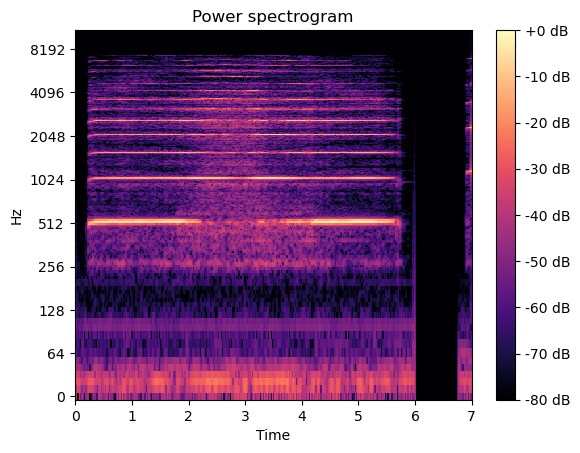

In [9]:
S_ref = np.abs(librosa.stft(ref[:sr*7]))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_ref,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

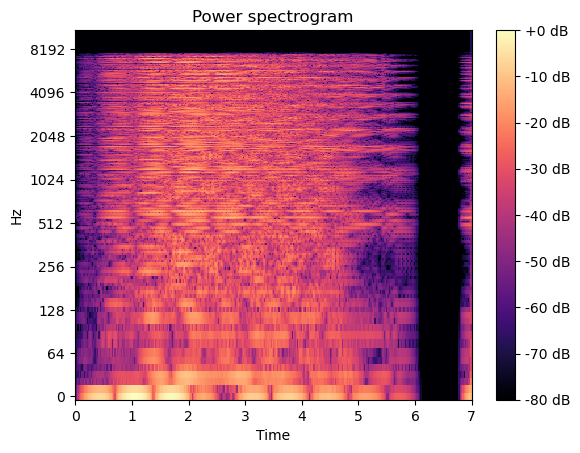

In [10]:
S_synth = np.abs(librosa.stft(synth[:sr*7]))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_synth,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")